In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [2]:
datapath = os.getcwd()
datapath

'/Volumes/SSD/personal/lung_seg'

In [3]:
# import kaggle
# kaggle.api.authenticate()
# kaggle.api.dataset_download_files('kmader/finding-lungs-in-ct-data', path=datapath, unzip=True)

In [4]:
path = Path(datapath)
path_imgs = path/'2d_images'
path_masks = path/'2d_masks'

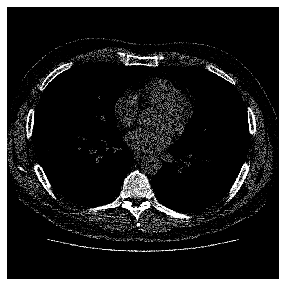

In [5]:
fnames = get_image_files(path_imgs)
img = open_image(fnames[0])
img.show(figsize=(5,5))

In [6]:
type(img)

fastai.vision.image.Image

In [7]:
print('\t'.join(dir(img)))

__class__	__delattr__	__dict__	__dir__	__doc__	__eq__	__format__	__ge__	__getattribute__	__gt__	__hash__	__init__	__init_subclass__	__le__	__lt__	__module__	__ne__	__new__	__reduce__	__reduce_ex__	__repr__	__setattr__	__sizeof__	__str__	__subclasshook__	__weakref__	_affine_mat	_flow	_logit_px	_maybe_add_crop_pad	_px	_repr_image_format	_repr_jpeg_	_repr_png_	affine	affine_mat	apply_tfms	brightness	clone	contrast	coord	crop	crop_pad	cutout	data	device	dihedral	dihedral_affine	flip_affine	flip_lr	flow	jitter	lighting	logit_px	pad	perspective_warp	pixel	px	refresh	resize	rgb_randomize	rotate	sample_kwargs	save	set_sample	shape	show	size	skew	squish	symmetric_warp	tilt	zoom	zoom_squish


In [8]:
img.data.shape

torch.Size([3, 512, 512])

In [9]:
img.data[0,...].max()


tensor(1.)

In [10]:
img.data[1,...].max()



tensor(1.)

In [11]:
img.data[2,...].max()

tensor(1.)

In [12]:
img.data[0,...].min()

tensor(0.)

(array([6.49305e+05, 3.39000e+03, 2.01900e+03, 3.24000e+03, ..., 2.79000e+02, 1.50000e+02, 2.43000e+02, 1.31400e+04]),
 array([0.  , 0.01, 0.02, 0.03, ..., 0.97, 0.98, 0.99, 1.  ], dtype=float32),
 <a list of 100 Patch objects>)

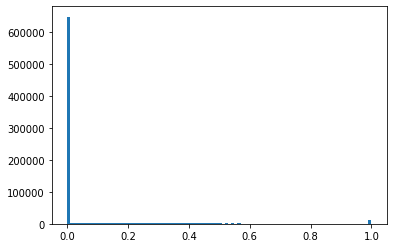

In [13]:
plt.hist(img.data.flatten(), bins=100) #range of image data is 0 ~ 1

In [14]:
get_y_fn = lambda x: path_masks/f'{x.name}'

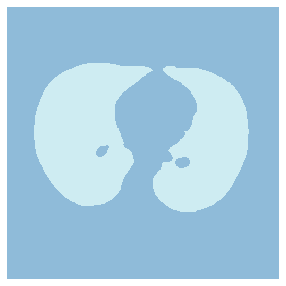

In [15]:
mask = open_mask(get_y_fn(fnames[0]))
mask.show(figsize=(5,5))

In [16]:
type(mask)


fastai.vision.image.ImageSegment

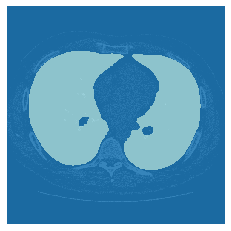

In [17]:
_, axs = plt.subplots()
img.show(ax=axs)
mask.show(ax=axs, alpha=0.9)

In [18]:
src_size = np.array(mask.shape[1:])
src_size

array([512, 512])

In [19]:
mask.data

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])

In [20]:
mask.data.max()

tensor(255)

In [21]:
mask.data.shape

torch.Size([1, 512, 512])

(array([192309.,      0.,      0.,      0., ...,      0.,      0.,      0.,  69835.]),
 array([  0.  ,   2.55,   5.1 ,   7.65, ..., 247.35, 249.9 , 252.45, 255.  ]),
 <a list of 100 Patch objects>)

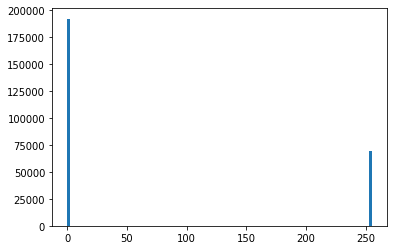

In [22]:
plt.hist(mask.data.flatten(), bins=100)#mask = [0, 250]

In [33]:
size =  src_size
bs = 8

In [34]:
# src = (SegmentationItemList.from_folder(path_imgs).split_by_rand_pct(0.2).label_from_func(get_y_fn,classes=codes))

In [35]:
src = (SegmentationItemList.from_folder(path_imgs).split_none().label_from_func(get_y_fn,classes=[0,1]))

In [36]:
src.y

SegmentationLabelList (267 items)
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: /Volumes/SSD/personal/lung_seg/2d_images

In [37]:
data=(src.transform(get_transforms(do_flip=False), size=size, tfm_y=True).databunch(bs=bs).normalize(imagenet_stats))

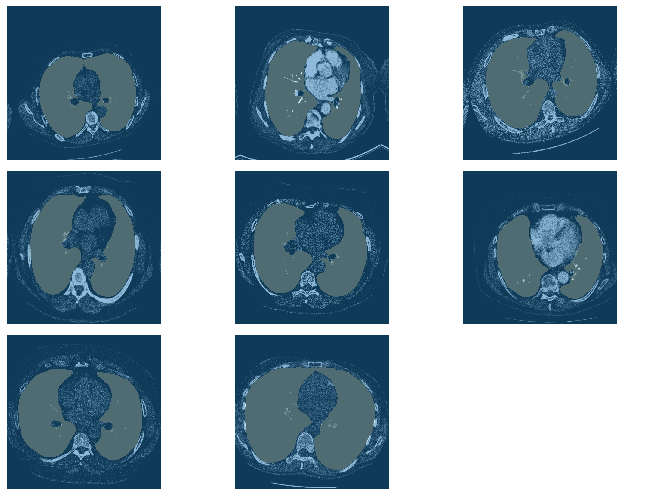

In [38]:
data.show_batch(4,figsize=(10,7))

In [39]:
def dice_loss(input, target):
    """Soft dice loss function.
    https://github.com/pytorch/pytorch/issues/1249"""
    # Input is of shape N,C,H,W
    smooth = 1
    batch_size = input.size(0)
    input = F.softmax(input, dim=1)
    # Since we have only 2 classes transform it to N,H,W and treat as sigmoid
    input = input.view(batch_size, 2, -1)[:, 1, :]
    target = make_one_hot(target).view(batch_size, 2, -1)[:, 1, :]

    inter = torch.sum(input * target) + smooth
    union = torch.sum(input) + torch.sum(target) + smooth

    return -torch.log(2.0 * inter / union)

In [40]:
metrics=dice

In [41]:
wd=1e-2

In [43]:
learn = unet_learner(data, models.vgg19_bn, metrics=metrics, wd=wd)


Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /Users/derekz/.cache/torch/checkpoints/vgg19_bn-c79401a0.pth
  6%|▋         | 34.5M/548M [00:12<03:08, 2.85MB/s]


KeyboardInterrupt: 